2D Classical Ising Model NLCE Code

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from tqdm import tqdm

In [189]:
def generate_spin_configurations(order):
    # generates a list of lists, where each list is a configuration of spins
    # of length 'order', with each spin being either +1 or -1.
    # e.g. for order 3
    # [[1,1,1],
    #  [1,1,-1],
    #  [1,-1,1],
    #  [1,-1,-1],
    #  [-1,1,1],
    #  [-1,1,-1],
    #  [-1,-1,1],
    #  [-1,-1,-1]]
    num_configs = 2**order
    configurations = np.zeros((num_configs, order), dtype=int)
    for i in range(num_configs):
        for j in range(order):
            if (i // (2**j)) % 2 == 0:
                configurations[i, j] = 1
            else:
                configurations[i, j] = -1
    return configurations

In [190]:
def calculate_cluster_info(beta, J, cluster_bonds):
    # calculates the partition function and energy for a given cluster
    if not cluster_bonds: # empty list, no bonds
        return 2.0, 0.0
    

    sites = set()
    for bond in cluster_bonds:
        sites.add(bond[0])
        sites.add(bond[1])
    
    site_list = sorted(list(sites))
    site_to_index = {site: i for i, site in enumerate(site_list)}
    num_sites = len(site_list)

    configurations = generate_spin_configurations(num_sites)
    
    # Calculate partition function and energy
    Z = 0.0
    E_sum = 0.0
    for config in configurations:
        energy_coeff = 0
        for bond in cluster_bonds:
            i = site_to_index[bond[0]]
            j = site_to_index[bond[1]]
            energy_coeff += config[i] * config[j]
        
        boltzmann_factor = np.exp(J * beta * energy_coeff)
        Z += boltzmann_factor
        E_sum += energy_coeff * boltzmann_factor
    
    # Calculate average energy
    E = -J * E_sum / Z
    
    return Z, E

In [191]:
def normalize_cluster(sites):
        # normalizes the clusters so they can be compared against other clusters for symmetrical distinction
        sites = sorted(sites)
        min_site = sites[0]
        normalized = [(x - min_site[0], y - min_site[1]) for x, y in sites]
        return tuple(sorted(normalized))

def get_canonical_form(sites):
        # checks for symmetrically indistinct versions of the cluster
        canonical_forms = set()
        
        # original cluster
        canonical_forms.add(normalize_cluster(sites))
        
        # 90 degree rotation
        rotated_90 = [(-y, x) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_90))

        # 180 degree rotation
        rotated_180 = [(-x, -y) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_180))

        # 270 degree rotation
        rotated_270 = [(y, -x) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_270))
        
        # reflection across x axis
        reflected_x = [(x, -y) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_x))

        # reflection across y axis
        reflected_y = [(-x, y) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_y))

        # reflection across y=x
        reflected_diag = [(y, x) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_diag))

        # reflection across y=-x
        reflected_antidiag = [(-y, -x) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_antidiag))
        
        # return minimized cluster
        return min(canonical_forms)

def calculate_multiplicity(sites):
        # calculates the multiplicity of a specific cluster

        canonical = normalize_cluster(sites)
        
        # count how many symmetry operations leave the cluster unchanged
        identical_count = 0
        
        transformations = [
            lambda x, y: (x, y),           # identity
            lambda x, y: (-y, x),          # 90 degree rotation
            lambda x, y: (-x, -y),         # 180 degree rotation
            lambda x, y: (y, -x),          # 270 degree rotation
            lambda x, y: (x, -y),          # reflection x axis
            lambda x, y: (-x, y),          # reflection y axis
            lambda x, y: (y, x),           # reflection y=x
            lambda x, y: (-y, -x),         # reflection y=-x
        ]
        
        for transform in transformations:
            transformed = [transform(x, y) for x, y in sites]
            if normalize_cluster(transformed) == canonical:
                identical_count += 1
        
        return 8 // identical_count

In [192]:
def count_embeddings(large_cluster_coords, small_cluster_coords):
    # calculates the number of embeddings for each small cluster in a large cluster
    # e.g. checks how many times a specific order 3 cluster appears in an order 4 cluster
    
    if len(small_cluster_coords) > len(large_cluster_coords):
        return 0
    
    if len(small_cluster_coords) == len(large_cluster_coords):
        # Same size - check if they're the same cluster (up to symmetry)
        return 1 if get_canonical_form(large_cluster_coords) == get_canonical_form(small_cluster_coords) else 0
    
    # Get canonical form of the small cluster
    small_canonical = get_canonical_form(small_cluster_coords)
    count = 0
    
    # Check all subsets of the appropriate size in the large cluster
    for subset in combinations(large_cluster_coords, len(small_cluster_coords)):
        subset_canonical = get_canonical_form(list(subset))
        if subset_canonical == small_canonical:
            count += 1
    
    return count

def calculate_weights(beta, J, orders, bonds, coordinates):
    # calculates the weights for each cluster in each order

    weights = {}
    
    # Process each order sequentially
    for order in sorted(orders):
        weights[order] = []
        
        # Process each cluster in this order
        for cluster_idx in range(len(bonds[order])):
            # get energy of specific cluster
            Z, E_raw = calculate_cluster_info(beta, J, bonds[order][cluster_idx])
            
            # calculate weight by subtracting embedded subclusters
            weight = E_raw
            for sub_order in range(1, order):
                if sub_order not in weights:
                    continue
                    
                for sub_cluster_idx in range(len(coordinates[sub_order])):
                    # Count how many times this subcluster appears in current cluster
                    embedding_count = count_embeddings(
                        coordinates[order][cluster_idx],
                        coordinates[sub_order][sub_cluster_idx]
                    )
                    
                    if embedding_count > 0:
                        weight -= embedding_count * weights[sub_order][sub_cluster_idx]
            
            weights[order].append(weight)
    
    return weights

In [193]:
def calculate_lattice_energy(beta, J, orders, multiplicities, bonds, coordinates):
    # computes the total energy of the lattice using weights, multiplicities, and clusters

    weights = calculate_weights(beta, J, orders, bonds, coordinates)

    lattice_energy = 0.0
    for order in orders:
        for idx, multiplicity in enumerate(multiplicities[order]):
            lattice_energy += multiplicity * weights[order][idx]

    return lattice_energy

In [194]:
def generate_clusters(order):
    # start with order 1 cluster (0,0) and build up to the desired order by adding neighboring sites to each point in the cluster
    # Once all possible clusters are generated, we will remove duplicates by checking for symmetrical equivalence
    # This way when we build clusters for the next order we only need to consider unique clusters from the previous order.

    clusters = {}
    multiplicities_dic = {1: [1]}
    
    clusters[1] = [[(0,0)]]
    
    neighboring_sites = [(1,0),(-1,0),(0,1),(0,-1)]
    
    for cluster_ord in range(2, order + 1):
        print(f"Generating clusters of order {cluster_ord}")
        clusters[cluster_ord] = []

        for prev_cluster in clusters[cluster_ord - 1]:
            prev_sites = set(prev_cluster)
            
            neighbor_candidates = set()
            for ci, cj in prev_cluster:
                for ni, nj in neighboring_sites:
                    new_site = (ci + ni, cj + nj)
                    if new_site not in prev_sites:
                        neighbor_candidates.add(new_site)
            
            for new_site in neighbor_candidates:
                new_cluster = prev_cluster + [new_site]
                clusters[cluster_ord].append(new_cluster)

        # remove duplicates
        unique_clusters = []
        unique_set = set()
        multiplicities = []
        for cluster in clusters[cluster_ord]:
            canonical = get_canonical_form(cluster)
            if canonical not in unique_set:
                unique_set.add(canonical)
                unique_clusters.append(cluster)

                multiplicity = calculate_multiplicity(cluster)
                multiplicities.append(multiplicity)
        
        multiplicities_dic[cluster_ord] = multiplicities
        clusters[cluster_ord] = unique_clusters
    
    return clusters, multiplicities_dic

def generate_bonds_from_clusters(clusters):
    # generate bonds for each cluster by connecting neighboring sites

    bonds = {}
    for order, cluster_list in clusters.items():
        bonds[order] = []
        for cluster in cluster_list:
            cluster_bonds = []
            site_set = set(cluster)
            for (x, y) in cluster:
                # Check right neighbor
                if (x + 1, y) in site_set:
                    cluster_bonds.append(((x, y), (x + 1, y)))
                # Check up neighbor
                if (x, y + 1) in site_set:
                    cluster_bonds.append(((x, y), (x, y + 1)))
            bonds[order].append(cluster_bonds)
    return bonds



In [197]:
J = 1
Ti = 0.1
Tf = 5.0
num_T = 20

orders = [1,2,3,4,5,6,7]
energies = {}
for order in orders:
    energies[order] = []

# generate clusters and bonds up to our max order
clusters, multiplicities = generate_clusters(np.max(orders))
bonds = generate_bonds_from_clusters(clusters)

# iterate over temperatures so we can plot against expected result
Temps = np.linspace(Ti, Tf, num_T)

print("Calculating energies over temperature range...")

for T in tqdm(Temps):
    beta = 1 / T
    weights = calculate_weights(beta, J, orders, bonds, clusters)

    for order in orders:
        lattice_energy = 0.0
        for ord in range(1, order + 1):
            for idx, multiplicity in enumerate(multiplicities[ord]):
                lattice_energy += multiplicity * weights[ord][idx]
        energies[order].append(lattice_energy)

Generating clusters of order 2
Generating clusters of order 3
Generating clusters of order 4
Generating clusters of order 5
Generating clusters of order 6
Generating clusters of order 7
Calculating energies over temperature range...


100%|██████████| 20/20 [00:55<00:00,  2.78s/it]


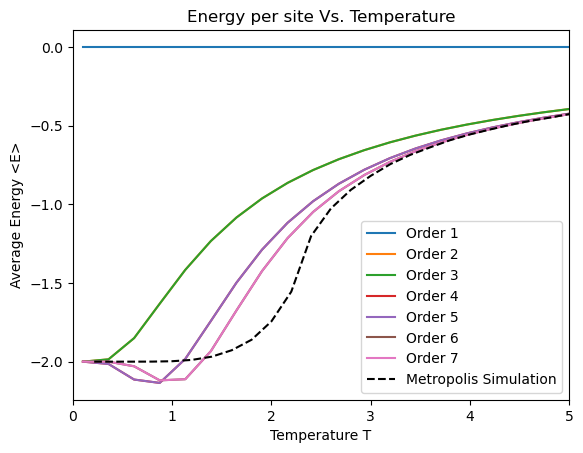

In [198]:
# plot results
for i in range(len(orders)):
    order = orders[i]
    plt.plot(Temps, energies[order], label=f'Order {order}')

metropolis = pd.read_csv("ising_metropolis_results.csv")
plt.plot(metropolis["T"], metropolis["Energy"], 'k--', label='Metropolis Simulation')
plt.xlabel('Temperature T')
plt.ylabel('Average Energy <E>')
plt.xlim(0,5)
plt.title("Energy per site Vs. Temperature")
plt.legend()
plt.show()

Save Data

In [ ]:
import json
file_path = f"energies_o{np.max(orders)}.json"
with open(file_path, "w") as json_file:
    json.dump(energies, json_file, indent=4)

file_path = f"clusters_o{np.max(orders)}.json"
with open(file_path, "w") as json_file:
    json.dump(clusters, json_file, indent=4)

file_path = f"bonds_o{np.max(orders)}.json"
with open(file_path, "w") as json_file:
    json.dump(bonds, json_file, indent=4)

file_path = f"multiplicities_o{np.max(orders)}.json"
with open(file_path, "w") as json_file:
    json.dump(multiplicities, json_file, indent=4)
